In [1]:
import os
import glob
import kagglehub
import json

# -----------------------------
# 1️⃣ Helper to download Kaggle datasets
# -----------------------------
def get_dataset_folder(kaggle_path):
    downloaded_path = kagglehub.dataset_download(kaggle_path)
    versioned_folders = glob.glob(os.path.join(downloaded_path, "versions/*"))
    if versioned_folders:
        folder = versioned_folders[0]
    else:
        folder = downloaded_path
    return folder

# -----------------------------
# 2️⃣ Define Kaggle datasets
# -----------------------------
datasets_info = {
    "hate_1": "sunandabiswas24/video-dataset-of-hate-speeches",
    "hate_2": "argfisher/repository-for-hate-videos",
    "hate_3": "argfisher/all-training-videos-for-hate-video-ml",
    "violence": "shreyj1729/cctv-fights-dataset",
    "non_hate": "argfisher/repository-for-non-hate-videos",
    "mixed": "pratt3000/moviesviolencenonviolence"
}

dataset_folders = {}
for key, kaggle_path in datasets_info.items():
    folder = get_dataset_folder(kaggle_path)
    dataset_folders[key] = folder
    print(f"{key} folder:", folder)

# -----------------------------
# 3️⃣ Video helper
# -----------------------------
VIDEO_EXTS = (".mp4", ".avi", ".mkv", ".mov", ".mpeg", ".mpg", ".wmv", ".flv")

def is_video(fname):
    return fname.lower().endswith(VIDEO_EXTS)

# -----------------------------
# 4️⃣ Combine datasets
# -----------------------------
data = {}
idx = 0

# ---- Hate datasets → label 0
for key in ["hate_1", "hate_2", "hate_3"]:
    folder = dataset_folders[key]
    for root, dirs, files in os.walk(folder):
        for f in files:
            if is_video(f):
                data[idx] = {"video_path": os.path.join(root, f), "label": 0}
                idx += 1

# ---- Violence (CCTV fights) → label 1
violence_path = dataset_folders["violence"]
cctv_dataset_path = os.path.join(violence_path, "dataset")
gt_file = os.path.join(cctv_dataset_path, "ground-truth.json")

with open(gt_file, "r") as f:
    gt = json.load(f)

# recursively collect videos
for root, dirs, files in os.walk(cctv_dataset_path):
    for f in files:
        if is_video(f):
            data[idx] = {"video_path": os.path.join(root, f), "label": 1}
            idx += 1

# ---- Non-Hate → label 2
folder = dataset_folders["non_hate"]
for root, dirs, files in os.walk(folder):
    for f in files:
        if is_video(f):
            data[idx] = {"video_path": os.path.join(root, f), "label": 2}
            idx += 1

# ---- Mixed dataset → Violence / NonViolence
mixed = dataset_folders["mixed"]

# Detect actual folders (case-insensitive)
viol_f = None
non_v_f = None
for root, dirs, files in os.walk(mixed):
    for d in dirs:
        if "violence" in d.lower():
            viol_f = os.path.join(root, d)
        elif "nonviolence" in d.lower():
            non_v_f = os.path.join(root, d)

# Safety check
if viol_f:
    for root, dirs, files in os.walk(viol_f):
        for f in files:
            if is_video(f):
                data[idx] = {"video_path": os.path.join(root, f), "label": 1}
                idx += 1

if non_v_f:
    for root, dirs, files in os.walk(non_v_f):
        for f in files:
            if is_video(f):
                data[idx] = {"video_path": os.path.join(root, f), "label": 2}
                idx += 1

print("\n✅ Total videos combined:", len(data))

# Optional: print dataset counts
from collections import Counter
labels = [v["label"] for v in data.values()]
print("Counts per label:", Counter(labels))


Using Colab cache for faster access to the 'video-dataset-of-hate-speeches' dataset.
hate_1 folder: /kaggle/input/video-dataset-of-hate-speeches
Using Colab cache for faster access to the 'repository-for-hate-videos' dataset.
hate_2 folder: /kaggle/input/repository-for-hate-videos
hate_3 folder: /root/.cache/kagglehub/datasets/argfisher/all-training-videos-for-hate-video-ml/versions/2
Using Colab cache for faster access to the 'cctv-fights-dataset' dataset.
violence folder: /kaggle/input/cctv-fights-dataset
Using Colab cache for faster access to the 'repository-for-non-hate-videos' dataset.
non_hate folder: /kaggle/input/repository-for-non-hate-videos
Using Colab cache for faster access to the 'moviesviolencenonviolence' dataset.
mixed folder: /kaggle/input/moviesviolencenonviolence

✅ Total videos combined: 2820
Counts per label: Counter({1: 1123, 0: 1045, 2: 652})


In [2]:
from collections import Counter
import os

# -----------------------------
# 1️⃣ Count by labels
# -----------------------------
labels = [v["label"] for v in data.values()]
label_counts = Counter(labels)

label_names = {0: "Hate", 1: "Violence", 2: "Non-Hate / Non-Violence"}

print("\n================= DATASET BIFURCATION =================\n")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} videos")

# -----------------------------
# 2️⃣ Optional: Count by original dataset
# -----------------------------
dataset_counts = Counter()
for idx, v in data.items():
    path = v["video_path"]
    if "video-dataset-of-hate-speeches" in path:
        dataset_counts["hate_1"] += 1
    elif "repository-for-hate-videos" in path:
        dataset_counts["hate_2"] += 1
    elif "all-training-videos-for-hate-video-ml" in path:
        dataset_counts["hate_3"] += 1
    elif "cctv-fights-dataset" in path:
        dataset_counts["violence_cctv"] += 1
    elif "repository-for-non-hate-videos" in path:
        dataset_counts["non_hate"] += 1
    elif "moviesviolencenonviolence" in path:
        if "Violence" in path or "violence" in path:
            dataset_counts["mixed_violence"] += 1
        else:
            dataset_counts["mixed_non_violence"] += 1

print("\n----------------- VIDEO COUNTS BY ORIGINAL DATASET -----------------\n")
for k, v in dataset_counts.items():
    print(f"{k}: {v} videos")

print("\nTotal combined videos:", sum(dataset_counts.values()))



================= DATASET BIFURCATION =================

Hate: 1045 videos
Violence: 1123 videos
Non-Hate / Non-Violence: 652 videos

----------------- VIDEO COUNTS BY ORIGINAL DATASET -----------------

hate_1: 83 videos
hate_2: 431 videos
hate_3: 531 videos
violence_cctv: 1000 videos
non_hate: 652 videos
mixed_violence: 123 videos

Total combined videos: 2820


In [3]:
# ================================
# ✅ 1. INSTALL FAST DEPENDENCIES
# ================================
!apt-get -q install -y ffmpeg
!pip install -q --upgrade pip
!pip install -q openai-whisper pandas tqdm

# ================================
# ✅ 2. IMPORTS & DEVICE
# ================================
import os
import subprocess
import torch
import whisper
import pandas as pd
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ DEVICE:", device)

# ================================
# ✅ 3. LOAD FASTEST WHISPER MODEL
# ================================
# tiny = FASTEST (3–5× faster than small)
whisper_model = whisper.load_model("tiny").to(device)
print("✅ WHISPER TINY LOADED")

# ================================
# ✅ 4. FAST AUDIO EXTRACTION (FFMPEG)
# ================================
def extract_audio_fast(video_path, out_wav="temp.wav"):
    # Overwrite temp.wav each time for speed
    cmd = f'ffmpeg -y -loglevel error -i "{video_path}" -ar 16000 -ac 1 -t 60 "{out_wav}"'
    subprocess.run(cmd, shell=True)
    return out_wav

# ================================
# ✅ 5. FAST TRANSCRIPTION FUNCTION
# ================================
def fast_transcribe(video_path):
    try:
        wav = extract_audio_fast(video_path)
        result = whisper_model.transcribe(
            wav,
            fp16=True   # GPU half-precision speedup
        )
        return result.get("text", "").strip()
    except Exception as e:
        return f"ERROR: {e}"

# ================================
# ✅ 6. PROCESS YOUR DATA (FAST BATCH)
# ================================
MAX_VIDEOS = 250   # ✅ SAFE FOR 30 MIN WITH TINY MODEL
subset = dict(list(data.items())[:MAX_VIDEOS])

results = []

for idx, meta in tqdm(subset.items()):
    video_path = meta["video_path"]
    text = fast_transcribe(video_path)

    results.append({
        "index": idx,
        "video_path": video_path,
        "ground_truth_label": meta["label"],
        "transcript": text[:500]
    })

# ================================
# ✅ 7. SAVE RESULTS
# ================================
df = pd.DataFrame(results)
df.to_csv("speech_fast.csv", index=False)

print("\n✅ DONE FAST LOCAL SPEECH EXTRACTION")
print("✅ Saved as: speech_fast.csv")
print(df.head())


Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
✅ DEVICE: cuda


100%|█████████████████████████████████████| 72.1M/72.1M [00:01<00:00, 72.0MiB/s]


✅ WHISPER TINY LOADED


100%|██████████| 250/250 [08:32<00:00,  2.05s/it]


✅ DONE FAST LOCAL SPEECH EXTRACTION
✅ Saved as: speech_fast.csv
   index                                         video_path  \
0      0  /kaggle/input/video-dataset-of-hate-speeches/H...   
1      1  /kaggle/input/video-dataset-of-hate-speeches/H...   
2      2  /kaggle/input/video-dataset-of-hate-speeches/H...   
3      3  /kaggle/input/video-dataset-of-hate-speeches/H...   
4      4  /kaggle/input/video-dataset-of-hate-speeches/H...   

   ground_truth_label                                         transcript  
0                   0  They don't be such a fucking smart ass. We're ...  
1                   0  You've done some crazy shit in the past, but t...  
2                   0  Okay, he's just a little care with the fuck wi...  
3                   0                                      fucking nuts!  
4                   0                                                     


In [4]:
# ================================
# ✅ 1. INSTALL FAST NLP MODEL
# ================================
!pip install -q transformers torch accelerate pandas

# ================================
# ✅ 2. LOAD DATA
# ================================
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

df = pd.read_csv("speech_fast.csv")

# ================================
# ✅ 3. LOAD PRETRAINED HATE MODEL
# ================================
model_name = "cardiffnlp/twitter-roberta-base-hate-latest"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print("✅ Hate Speech Model Loaded On:", device)

# ================================
# ✅ 4. FAST BATCH PREDICTION
# ================================
labels_map = {
    0: "non-hate",
    1: "hate"
}

predictions = []

batch_size = 32

for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df["transcript"].iloc[i:i+batch_size].fillna("").tolist()

    inputs = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

    predictions.extend([labels_map[p] for p in preds])

df["speech_prediction"] = predictions

# ================================
# ✅ 5. FINAL 3-CLASS OUTPUT
# ================================
final_labels = []
for gt, speech in zip(df["ground_truth_label"], df["speech_prediction"]):
    if speech == "hate":
        final_labels.append("HATE")
    elif gt == 1:
        final_labels.append("VIOLENCE")
    else:
        final_labels.append("NON-HATE / NON-VIOLENCE")

df["final_output"] = final_labels

# ================================
# ✅ 6. SAVE FINAL RESULT
# ================================
df.to_csv("final_predictions.csv", index=False)

print("\n✅ FINAL CLASSIFICATION COMPLETED")
print(df[["video_path", "speech_prediction", "final_output"]].head())
print("\n✅ Saved as: final_predictions.csv")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

✅ Hate Speech Model Loaded On: cuda


 12%|█▎        | 1/8 [00:00<00:01,  6.02it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

100%|██████████| 8/8 [00:01<00:00,  5.15it/s]



✅ FINAL CLASSIFICATION COMPLETED
                                          video_path speech_prediction  \
0  /kaggle/input/video-dataset-of-hate-speeches/H...              hate   
1  /kaggle/input/video-dataset-of-hate-speeches/H...          non-hate   
2  /kaggle/input/video-dataset-of-hate-speeches/H...          non-hate   
3  /kaggle/input/video-dataset-of-hate-speeches/H...              hate   
4  /kaggle/input/video-dataset-of-hate-speeches/H...          non-hate   

              final_output  
0                     HATE  
1  NON-HATE / NON-VIOLENCE  
2  NON-HATE / NON-VIOLENCE  
3                     HATE  
4  NON-HATE / NON-VIOLENCE  

✅ Saved as: final_predictions.csv


In [7]:
!apt-get -y install ffmpeg
!pip install -q streamlit openai-whisper opencv-python reportlab torch ffmpeg-python pyngrok


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [14]:
from google.colab import files

uploaded = files.upload()  # choose a video file
video_path = list(uploaded.keys())[0]
print("Uploaded video:", video_path)


Saving H82.mp4 to H82.mp4
Uploaded video: H82.mp4


In [15]:
import whisper
import torch
import subprocess
import tempfile

device = "cuda" if torch.cuda.is_available() else "cpu"
model = whisper.load_model("tiny").to(device)
print("✅ Whisper tiny loaded on", device)

def extract_audio(video_path, wav_path):
    cmd = f'ffmpeg -y -loglevel error -i "{video_path}" -ar 16000 -ac 1 "{wav_path}"'
    subprocess.run(cmd, shell=True)

def transcribe(video_path):
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        wav_path = tmp.name

    extract_audio(video_path, wav_path)
    result = model.transcribe(wav_path, fp16=True)
    return result["text"]

transcript = transcribe(video_path)
print("\n✅ Transcript:\n", transcript[:500], "...\n")  # show first 500 chars


✅ Whisper tiny loaded on cuda

✅ Transcript:
  I want you to get in the goddamn game. I won't let you fucking promise me. ...



In [16]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

pdf_path = "transcript.pdf"

c = canvas.Canvas(pdf_path, pagesize=letter)
width, height = letter
y = height - 40

for line in transcript.split("\n"):
    if y < 40:
        c.showPage()
        y = height - 40
    c.drawString(40, y, line)
    y -= 14

c.save()
print("✅ Transcript saved as PDF:", pdf_path)

# Download PDF
files.download(pdf_path)


✅ Transcript saved as PDF: transcript.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

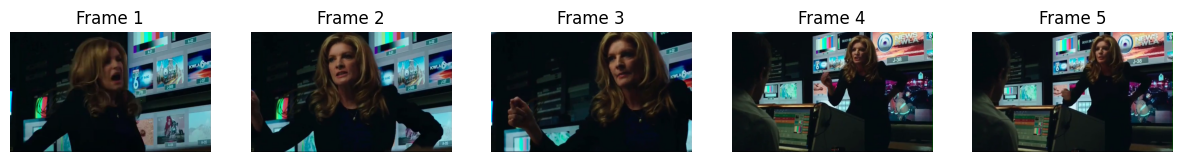

In [17]:
import cv2
from matplotlib import pyplot as plt

N = 5  # number of frames to display

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interval = max(1, total_frames // N)

frames = []
idx = 0
saved = 0

while cap.isOpened() and saved < N:
    ret, frame = cap.read()
    if not ret:
        break
    if idx % interval == 0:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
        saved += 1
    idx += 1
cap.release()

# Display frames
plt.figure(figsize=(15,5))
for i, frame in enumerate(frames):
    plt.subplot(1, N, i+1)
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"Frame {i+1}")
plt.show()


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load hate speech model
model_name = "cardiffnlp/twitter-roberta-base-hate-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

labels_map = {0:"non-hate", 1:"hate"}

inputs = tokenizer(transcript, return_tensors="pt", truncation=True, max_length=128).to(device)
with torch.no_grad():
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

speech_prediction = labels_map[pred]
print("✅ Speech Prediction:", speech_prediction)

# Combine with Violence / Non-Hate logic (if you want):
# For testing purposes, assume the video is not labeled violent
final_output = "HATE" if speech_prediction=="hate" else "NON-HATE / NON-VIOLENCE"
print("✅ Final Output:", final_output)


✅ Speech Prediction: non-hate
✅ Final Output: NON-HATE / NON-VIOLENCE


In [19]:
import pickle


In [20]:
# Create a dictionary to hold everything
data_to_save = {
    "video_path": video_path,
    "transcript": transcript,
    "speech_prediction": speech_prediction,
    "final_output": final_output,
    "frames": frames  # list of N extracted frames (as RGB numpy arrays)
}


In [21]:
pkl_path = "video_analysis.pkl"

with open(pkl_path, "wb") as f:
    pickle.dump(data_to_save, f)

print("✅ Data saved as:", pkl_path)


✅ Data saved as: video_analysis.pkl
